In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.layers import MaxPooling2D as KMaxPooling2D
 
from deconvnet.deconv2D import Deconv2D
from deconvnet.pool_unpool import MaxPooling2D, UndoMaxPooling2D
from deconvnet.forward_backward import truncated_model, backward_network

## Import images

Original images :

In [9]:
cat = plt.imread("images/cat.jpg")
cat2 = plt.imread("images/cat2.jpeg")

Images cropped to fit into VGG16 (224, 224) :

In [6]:
sz = 224
cat = plt.imread("images/cat.jpg")[112-sz//2:112+sz//2, 250-sz//2:250+sz//2]
cat2 = plt.imread("images/cat2.jpeg")[112-sz//2:112+sz//2, 160-sz//2:160+sz//2]

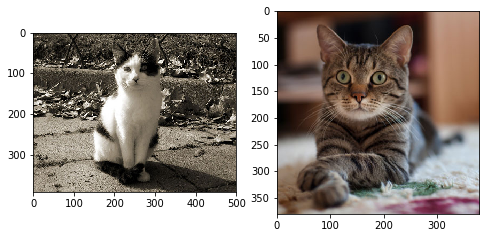

In [10]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cat)
plt.subplot(1,2,2)
plt.imshow(cat2)
plt.show()

In [7]:
print(cat.shape, cat2.shape)

(224, 224, 3) (224, 224, 3)


## Define the networks

We define the VGG network according to the picture we want to analyze :

In [44]:
vgg16 = VGG16(include_top=False, weights=None, input_tensor=None,
               input_shape=cat.shape, pooling=None, classes=1000)

In [28]:
vgg16 = VGG16(include_top=False, weights=None, input_tensor=None,
               input_shape=cat2.shape, pooling=None, classes=1000)

We can now define the forward and backward truncated convnet and deconvnet :

In [45]:
network = truncated_model(vgg16, "block5_conv3") # Last convolutional layer
reverse_net = backward_network(network)
network.load_weights("vgg16_weights.h5", by_name=True)
reverse_net.load_weights("vgg16_weights.h5", by_name=True)

## Reverse propagation for sample filters

In [46]:
forward_output = network.predict(cat[None])
_, _, _, filters = forward_output[0].shape
f0 = forward_output[0]

In [ ]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0, hspace=0)
for i in tqdm(range(25)):
    f = f0.copy()
    forward_output[0] = f
    forward_output[0][:, :, :, np.arange(filters) != i] = 0
    backward_output = reverse_net.predict(forward_output)
    img = np.floor(255*backward_output[0]/backward_output[0].max()).astype(np.int32)
    plt.subplot(5,5,i+1)
    plt.imshow(img)

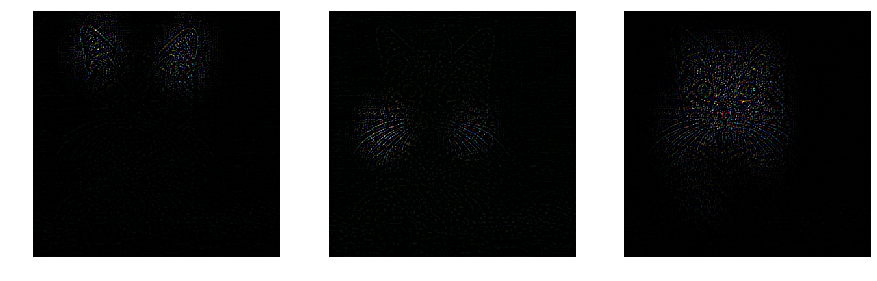

In [43]:
# Interesting filters : i = 70 for ears, 214 for mustache, 286 for face
plt.figure(figsize=(15,5))
for j, i in enumerate([70, 214, 286]):
    f = f0.copy()
    forward_output[0] = f
    forward_output[0][:, :, :, np.arange(filters) != i] = 0
    backward_output = reverse_net.predict(forward_output)
    img = np.floor(255*backward_output[0]/backward_output[0].max()).astype(np.int32)
    plt.subplot(1,3,j+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

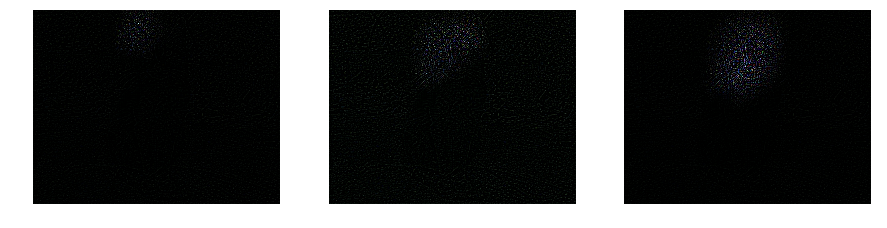

In [47]:
# i = 70 for ears, 214 for mustache, 286 for face
plt.figure(figsize=(15,5))
for j, i in enumerate([70, 214, 286]):
    f = f0.copy()
    forward_output[0] = f
    forward_output[0][:, :, :, np.arange(filters) != i] = 0
    backward_output = reverse_net.predict(forward_output)
    img = np.floor(255*backward_output[0]/backward_output[0].max()).astype(np.int32)
    plt.subplot(1,3,j+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()